In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as pdr
import warnings

yf.pdr_override() 
plt.style.use("fivethirtyeight")
warnings.filterwarnings("ignore")

yesterday = datetime.now() - timedelta(1)
yesterday = datetime.strftime(yesterday, '%Y-%m-%d')
today = datetime.strftime(datetime.now(), '%Y-%m-%d')

In [2]:
## FUNCTIONS
def getData(ticker="SPY", start="1994-01-01", end=today, interval='1MO'):
    data = yf.download(tickers=ticker, interval=interval, start=start, end=end)
    data.dropna(axis=0, inplace=True)
    return data.reset_index()

def funcMomentum(data, momentum='simple'):
    data['shift1'] = data['Adj Close'].shift(1)
    data['shift3'] = data['Adj Close'].shift(3)
    data['shift6'] = data['Adj Close'].shift(6)
    data.drop(['Open','High','Low', 'Close', 'Volume'], axis=1, inplace=True)
    data.dropna(axis=0, inplace=True)
    composite = (12*(data['Adj Close']/data['shift1']-1)) + (4*(data['Adj Close']/data['shift3']-1)) + (2*(data['Adj Close']/data['shift6']-1))
    simple = ((data['Adj Close']/data['shift6']-1))
    if momentum == 'composite':
        data['momentum'] = composite
    else:
        data['momentum'] = simple
    return data

def acceleratingDualMomentum(interval='1MO', stocks=["spy","scz","tip"], momentum='simple'):
    ## Getting Data
    namespace = globals()
    for i in stocks:
        namespace['%s_data' % str(i)] = getData(ticker=i, end=today, interval=interval)

    ## Creating shift columns and calculating momentum
    for i in stocks:
        namespace['%s_data' % str(i)] = funcMomentum(namespace['%s_data' % str(i)], momentum)
        
    ## series lenght ## hardcoded because ETF release date won't change.
    date = scz_data['Date'] 
    spy_data2 = spy_data.copy()
    spy_data2 = spy_data2.iloc[0:len(date)]
    tip_data2 = tip_data.copy()
    tip_data2 = tip_data.iloc[0:len(date)]

    
    ## ETF Picking
    etf = []
    ret = []
    for i in range(0, len(date)):
        if ((spy_data2['momentum'].iloc[i] > scz_data['momentum'].iloc[i]) & (spy_data2['momentum'].iloc[i] > 0)):
            etf.append('SPY')
            ret.append((spy_data2['Adj Close'].iloc[i] / spy_data2['shift1'].iloc[i] - 1)*100)
        elif ((scz_data['momentum'].iloc[i] > spy_data2['momentum'].iloc[i]) & (scz_data['momentum'].iloc[i] > 0)):
            etf.append('SCZ')
            ret.append((scz_data['Adj Close'].iloc[i] / scz_data['shift1'].iloc[i] - 1)*100)
        else:
            etf.append('TIP')
            ret.append((tip_data2['Adj Close'].iloc[i] / tip_data2['shift1'].iloc[i] - 1)*100)
   
    ## Returns        
    ret_data = {'date':date, 'etf':etf, 'ret':ret, 'Cumulative Returns':np.cumsum(ret)}
    returns = pd.DataFrame(data=ret_data)
    return returns

In [3]:
monthly = acceleratingDualMomentum(interval='1MO', momentum='simple')
weekly = acceleratingDualMomentum(interval='1WK', momentum='simple')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# print(len(monthly[monthly['ret']<0]))
# monthly[monthly['ret']<0]
monthly.tail(15)

,date,etf,ret,Cumulative Returns
163,2021-08-01 00:00:00-04:00,SCZ,2.810194,288.949121
164,2021-09-01 00:00:00-04:00,SPY,3.381012,292.330133
165,2021-10-01 00:00:00-04:00,SPY,1.837462,294.167595
166,2021-11-01 00:00:00-04:00,TIP,-0.063210,294.104385
167,2021-12-01 00:00:00-05:00,TIP,0.544503,294.648888
168,2022-01-01 00:00:00-05:00,TIP,-0.273712,294.375177
169,2022-02-01 00:00:00-05:00,TIP,-1.052041,293.323135
170,2022-03-01 00:00:00-05:00,TIP,1.028377,294.351513
171,2022-04-01 00:00:00-04:00,TIP,-0.389208,293.962305
172,2022-05-01 00:00:00-04:00,TIP,0.143238,294.105543


In [5]:
print("Monthly: ", monthly['Cumulative Returns'].tail(1))
print("Weekly: ", weekly['Cumulative Returns'].tail(1))

Monthly:  177    292.725092
Name: Cumulative Returns, dtype: float64
Weekly:  774    569.768295
Name: Cumulative Returns, dtype: float64


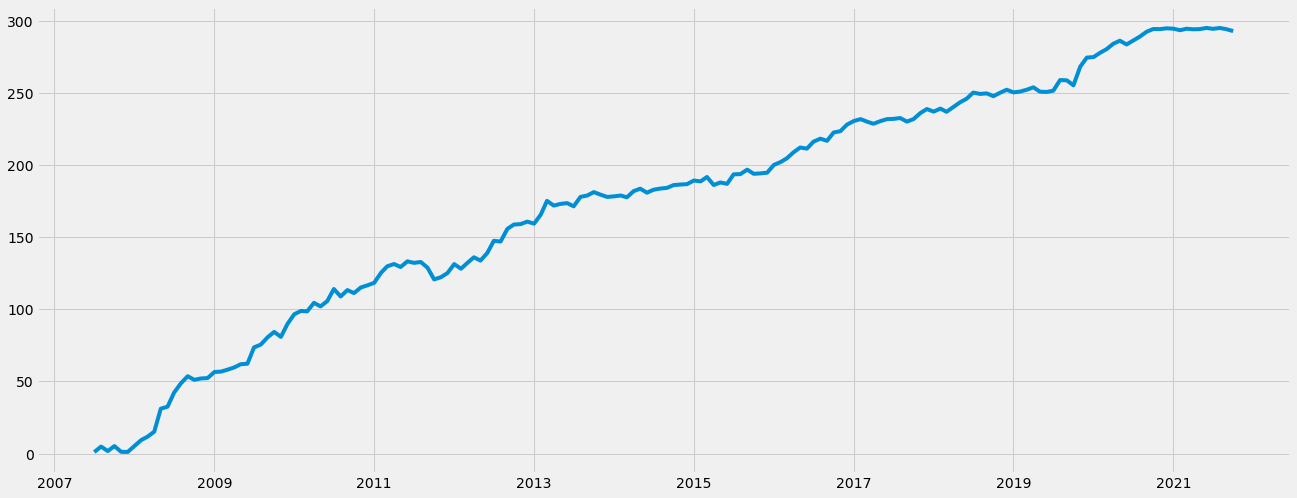

In [6]:
plt.figure(figsize=(20,8))
# plt.plot(weekly['date'], weekly['Cumulative Returns']*100);
# plt.plot(weekly['date'], weekly['ret']);
plt.plot(monthly['date'], monthly['Cumulative Returns']);
# plt.plot(monthly['date'], monthly['ret']);